# XGBoost

This notebook shows our process for selecting hyperparameters and features for the xgboost model

In [0]:
from pyspark.sql import types, Window, functions as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StringIndexer, StringIndexerModel
from sparkdl.xgboost import XgboostClassifier, XgboostClassifierModel
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics

# Good links

- [Data Clean](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324234161/command/1898361324234162)
- [Ester Feature Eng](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324251838/command/1898361324251866)
- [Weather var dictionary](https://docs.google.com/spreadsheets/d/1xthRtOjC5-kV0LMIRa_grkxZ6sLBlpqDpNwygOH_jlA/edit#gid=1829391731)

# Functions and global objects for data cleaning

In [0]:
%run ../Phase_3/dataclean_functions

In [0]:
# Metrics Functions
def evaluate_metrics(df):
    '''pass in dataframe with 2 columns: prediction, label
    '''
    
    result_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': [], 'f2_score_package': []}
    
    df = df.select('prediction', 'label')
    
    metrics = MulticlassMetrics(df.rdd)
    
    # classification metrics
    cm = metrics.confusionMatrix().toArray()
    accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
    precision = (cm[1][1]) / (cm[1][1] + cm[0][1])
    recall = (cm[1][1]) / (cm[1][1] + cm[1][0])
    
    def f_score(beta, precision, recall):
        return (1+beta**2) * precision * recall / (beta**2 * precision + recall)
    
    # save all metrics
    result_metrics['accuracy'].append(accuracy)
    result_metrics['precision'].append(precision)
    result_metrics['recall'].append(recall)
    result_metrics['f0_5_score'].append(f_score(0.5, precision, recall))
    result_metrics['f1_score'].append(f_score(1, precision, recall))
    result_metrics['f2_score'].append(f_score(2, precision, recall))
    result_metrics['f2_score_package'].append(metrics.weightedFMeasure(2.0))
    
    return result_metrics



# Function that saves all metrics from every cross validation run to a dictionary
# loop this across all grid search 
def evaluate_cross_folds(folds, model, features, y_var='DEP_DEL15_AIRLNS', verbose=True):
    '''
    Function to run through the proper cross validation with your single model and evaluate performance metrics on each fold
    
    Inputs:
    - folds: Use Yi's make_cv_folds(df) function and pass this object in
    - model: pass in a single model object to be evaluate
    - features: list of features to use as explanatory variables
    
    Output:
    - Dictionary of the main classification metrics for each k-fold CV
    '''
    
    all_metrics_train = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': [], 'f2_score_package': []}
    all_metrics_dev = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': [], 'f2_score_package': []}
    
    for i, fold_i in enumerate(folds):
        
        if verbose:
            print(f'Fitting model {i+1} of {len(folds)}')
        
        train = undersample(fold_i[0])
        dev = fold_i[1]
        
        # select fields we're using
        train = train.select(features + [y_var])
        dev = dev.select(features + [y_var])

        # put data into the pyspark form
        vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features', handleInvalid='skip')
        train = vectorAssembler.transform(train).select(['features', y_var])
        dev = vectorAssembler.transform(dev).select(['features', y_var])

        # cache data
        #train.cache()
        #dev.cache()
        
        # fit model
        model_fit = model.fit(train)
        
        # make preds
        train_pred = model_fit.transform(train)
        dev_pred = model_fit.transform(dev)
        dev_pred.cache()
        
        # calculate all metrics and append them to the dictionary
        results_train = evaluate_metrics(train_pred.withColumnRenamed(y_var, "label").select(['prediction', 'label']))
        results_dev = evaluate_metrics(dev_pred.withColumnRenamed(y_var, "label").select(['prediction', 'label']))
        
        for j in ['accuracy', 'precision', 'recall', 'f0_5_score', 'f1_score', 'f2_score', 'f2_score_package']:
            all_metrics_train[j].append(results_train[j])
            all_metrics_dev[j].append(results_dev[j])
        
    return all_metrics_train, all_metrics_dev

# Read in Data

In [0]:
blob_container = "main-storage" # The name of your container created in https://portal.azure.com
storage_account = "team05w261" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team05-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# Configure blob storage account access key globally
spark.conf.set(
  f"fs.azure.account.key.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")
df_train = df.filter(F.col('YEAR_AIRLNS') <= 2018)
# df_numrows = df.count()
# print(f"number of rows: {df_numrows}")
# print(f"number of columns: {len(df.columns)}")
# display(df)

# GBT

Use a GBT model just for extracting feature importances

In [0]:
spark.catalog.clearCache()

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018).sample(.1, seed=1)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# undersample train
df_train = undersample(df_train)

# select fields we're using
df_train = df_train.select(X_vars + [y_var])
df_test = df_test.select(X_vars + [y_var])

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

# cache data
df_train.cache()
df_test.cache()
print(f'train row count {df_train.count()}')
print(f'test row count {df_test.count()}')

# fit model
gbt_fit = GBTClassifier(featuresCol='features', labelCol=y_var, seed=1
                       ,featureSubsetStrategy='sqrt'
                       ,subsamplingRate=.8
                       ,maxBins=370
                       ,stepSize=.1
                       ,maxIter=50 # increase later to 100
                       ,maxDepth=12 # maybe make 15 later
                      )
gbt_fit = gbt_fit.fit(df_train)

# make preds
df_train = gbt_fit.transform(df_train)
df_test = gbt_fit.transform(df_test)
df_train.cache()
df_test.cache()
print(df_train.count())
print(df_test.count())

tr_metrics = evaluate_metrics(df_train.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
te_metrics = evaluate_metrics(df_test.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
print(tr_metrics)
print(te_metrics)

train row count 862278
test row count 7268232
862278
7268232
{'accuracy': [0.8077638534208225], 'precision': [0.7719681374007885], 'recall': [0.8731127082288707], 'f0_5_score': [0.7902778734970441], 'f1_score': [0.8194310849864868], 'f2_score': [0.8508175961772069]}
{'accuracy': [0.7576651378216875], 'precision': [0.90834987178562], 'recall': [0.7810147574556116], 'f0_5_score': [0.8796660657536113], 'f1_score': [0.8398834005612161], 'f2_score': [0.8035433644062916]}

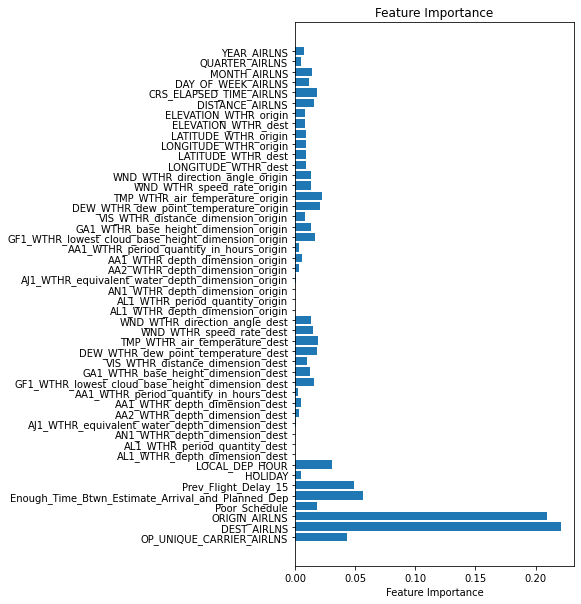

In [0]:
# varimp plot

list_extract = []
for i in df_train.schema['features'].metadata["ml_attr"]["attrs"]:
    list_extract = list_extract + df_train.schema['features'].metadata["ml_attr"]["attrs"][i]
varlist = pd.DataFrame(list_extract)
varlist['score'] = varlist['idx'].apply(lambda x: gbt_fit.featureImportances[x])
varlist.sort_values('score', ascending = False)

fig, ax = plt.subplots(figsize=(5, 10))
x = np.arange(len(varlist.name))
ax.barh(x, varlist.score)
ax.set_yticks(np.arange(len(varlist.name)))
ax.set_yticklabels(varlist.name)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance')
print("")

# XGBoost Cross Validation

In [0]:
# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin', 'SLP_WTHR_sea_level_pressure_origin',
    'GA1_WTHR_coverage_code_origin-00', 'GF1_WTHR_total_coverage_code_origin-00', 'AA1_WTHR_condition_code_origin-3', 'AU1_WTHR_descriptor_code_origin-0',
    'AU1_WTHR_descriptor_code_origin-7', 'AU1_WTHR_obscuration_code_origin-0', 'AU1_WTHR_other_weather_phenomena_code_origin-0', 

    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest', 'SLP_WTHR_sea_level_pressure_dest', 
    'GA1_WTHR_coverage_code_dest-00', 'GF1_WTHR_total_coverage_code_dest-00', 'AA1_WTHR_condition_code_dest-3',
    'AU1_WTHR_descriptor_code_dest-7', 'AU1_WTHR_obscuration_code_dest-0', 'AU1_WTHR_other_weather_phenomena_code_dest-0', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
    ]

y_var = 'DEP_DEL15_AIRLNS'

df = df_train.sample(.1, seed=1)

df = df.select(X_vars + [y_var])
df = df.na.fill(0)
# index cat vars
# str_cols = [t[0] for t in df.dtypes if t[1] == 'string']
str_cols = ['ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS']
for col in str_cols:
    df = df.withColumnRenamed(col, col+'_old')
    
# indexer = StringIndexer(inputCols=[i+'_old' for i in str_cols], outputCols=str_cols)
# xgb_indexer = indexer.fit(df)
# xgb_indexer.save('files/shared_uploads/trevorj@berkeley.edu/xgb_indexer_1')
xgb_indexer = StringIndexerModel.load('dbfs:/' + 'files/shared_uploads/trevorj@berkeley.edu/xgb_indexer_1')
df = xgb_indexer.transform(df)
df = df.drop(*[i+'_old' for i in str_cols])

# we undersample in evaluate_cross_folds
# df = undersample(df)
folds = make_cv_folds(df)

# define XGB to tune
# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['lambda'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []
cv_results_all['train_f2_score_package'] = []
cv_results_all['test_f2_score_package'] = []


# this tests out 3*2 = 6 configurations
for max_depth_ in [5, 7]:
    for n_estimators_ in [50]:
        for learning_rate_ in [.05]:
            for gamma_ in [.05]:
                for lambda_ in [.05]:
                    xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                            ,max_depth=max_depth_
                                            ,n_estimators=n_estimators_
                                            ,learning_rate=learning_rate_
                                            ,colsample_bytree=.8 
                                            ,gamma=gamma_
                                            ,reg_alpha=0 
                                            ,reg_lambda=lambda_
                                            ,min_child_weight=0)
                    
                    xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                    cv_results_all['max_depth'].append(max_depth_)
                    cv_results_all['n_estimators'].append(n_estimators_)
                    cv_results_all['learning_rate'].append(learning_rate_)
                    cv_results_all['gamma'].append(gamma_)
                    cv_results_all['lambda'].append(lambda_)
                    cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                    cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                    cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                    cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))
                    cv_results_all['train_f2_score_package'].append(np.mean(xgb_results[0]['f2_score_package']))
                    cv_results_all['test_f2_score_package'].append(np.mean(xgb_results[1]['f2_score_package']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df.sort_values('test_f2_score_package', ascending=False)

Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Out[64]:

,max_depth,n_estimators,learning_rate,gamma,lambda,train_f1_score,test_f1_score,train_f2_score,test_f2_score,train_f2_score_package,test_f2_score_package
0,5,50,0.05,0.05,0.05,0.679815,0.510888,0.629585,0.556037,0.713292,0.804025
1,7,50,0.05,0.05,0.05,0.692919,0.516390,0.647229,0.567987,0.722247,0.802418


In [0]:
# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin', 'SLP_WTHR_sea_level_pressure_origin',
    'GA1_WTHR_coverage_code_origin-00', 'GF1_WTHR_total_coverage_code_origin-00', 'AA1_WTHR_condition_code_origin-3', 'AU1_WTHR_descriptor_code_origin-0',
    'AU1_WTHR_descriptor_code_origin-7', 'AU1_WTHR_obscuration_code_origin-0', 'AU1_WTHR_other_weather_phenomena_code_origin-0', 

    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest', 'SLP_WTHR_sea_level_pressure_dest', 
    'GA1_WTHR_coverage_code_dest-00', 'GF1_WTHR_total_coverage_code_dest-00', 'AA1_WTHR_condition_code_dest-3',
    'AU1_WTHR_descriptor_code_dest-7', 'AU1_WTHR_obscuration_code_dest-0', 'AU1_WTHR_other_weather_phenomena_code_dest-0', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
    ]

y_var = 'DEP_DEL15_AIRLNS'

df = df_train.sample(.1, seed=1)

df = df.select(X_vars + [y_var])
df = df.na.fill(0)
# index cat vars
# str_cols = [t[0] for t in df.dtypes if t[1] == 'string']
str_cols = ['ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS']
for col in str_cols:
    df = df.withColumnRenamed(col, col+'_old')
    
# indexer = StringIndexer(inputCols=[i+'_old' for i in str_cols], outputCols=str_cols)
# xgb_indexer = indexer.fit(df)
# xgb_indexer.save('files/shared_uploads/trevorj@berkeley.edu/xgb_indexer_1')
xgb_indexer = StringIndexerModel.load('dbfs:/' + 'files/shared_uploads/trevorj@berkeley.edu/xgb_indexer_1')
df = xgb_indexer.transform(df)
df = df.drop(*[i+'_old' for i in str_cols])

# we undersample in evaluate_cross_folds
# df = undersample(df)
folds = make_cv_folds(df)

# define XGB to tune
# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['lambda'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []
cv_results_all['train_f2_score_package'] = []
cv_results_all['test_f2_score_package'] = []



for max_depth_ in [7]:
    for n_estimators_ in [50]:
        for learning_rate_ in [.05]:
            for gamma_ in [.05]:
                for lambda_ in [.05]:
                    xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                            ,max_depth=max_depth_
                                            ,n_estimators=n_estimators_
                                            ,learning_rate=learning_rate_
                                            ,colsample_bytree=.8 
                                            ,gamma=gamma_
                                            ,reg_alpha=0 
                                            ,reg_lambda=lambda_
                                            ,min_child_weight=0)
                    
                    xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                    cv_results_all['max_depth'].append(max_depth_)
                    cv_results_all['n_estimators'].append(n_estimators_)
                    cv_results_all['learning_rate'].append(learning_rate_)
                    cv_results_all['gamma'].append(gamma_)
                    cv_results_all['lambda'].append(lambda_)
                    cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                    cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                    cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                    cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))
                    cv_results_all['train_f2_score_package'].append(np.mean(xgb_results[0]['f2_score_package']))
                    cv_results_all['test_f2_score_package'].append(np.mean(xgb_results[1]['f2_score_package']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df.sort_values('test_f2_score_package', ascending=False)

# Data Clean

In [0]:
def clean_data_for_tree_model(df):

    # cast to int
    str_cols = ['Prev_Flight_Delay_15', 'Poor_Schedule', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep']
    for column in str_cols:
        df = df.withColumn(column, F.col(column).cast(types.IntegerType())) 

    # impute some missing values
    df = df.na.fill({
        'LATITUDE_WTHR_origin': 0
        ,'LONGITUDE_WTHR_origin': 0
        ,'ELEVATION_WTHR_origin': 0
        ,'LATITUDE_WTHR_dest': 0
        ,'LONGITUDE_WTHR_dest': 0
        ,'ELEVATION_WTHR_dest': 0
        ,'Prev_Flight_Delay_15': 0
        #,'DEP_DEL15_AIRLNS': 0
    })

    # vars to index
    # Specify which columns to index (ie cast to int)
    vars_to_index = [
        'ORIGIN_AIRLNS', 
        'DEST_AIRLNS', 
        'OP_UNIQUE_CARRIER_AIRLNS' # a more granular form of origin/dest airlines
    ]

    # rename cols to drop them later
    for var in vars_to_index:
        df = df.withColumnRenamed(var, var+'_old')

    # finally, index them
    indexer = StringIndexer(inputCols=[i+'_old' for i in vars_to_index], outputCols=vars_to_index)
    df = indexer.fit(df).transform(df)
    df = df.drop(*[i+'_old' for i in vars_to_index])

    # drop missing values from Y var
    df = df.filter(~F.col('DEP_DEL15_AIRLNS').isNull())
    
    return df

In [0]:
def clean_data_for_tree_model2(df):

    # cast to int
    str_cols = ['Prev_Flight_Delay_15', 'Poor_Schedule', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep']
    for column in str_cols:
        df = df.withColumn(column, F.col(column).cast(types.IntegerType())) 
    
    # drop missing values from Y var
    df = df.filter(~F.col('DEP_DEL15_AIRLNS').isNull())

    # impute some missing values
    df = df.na.fill(0)
    
    # get fields
    features = [i for i in df.columns if i != "DEP_DEL15_AIRLNS"]
    str_cols = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] in features]
    # drop some features
    features.remove('FL_DATE_AIRLNS')
    
    # index all str columns    
    vars_to_index = str_cols

    # rename cols to drop them later
    for var in vars_to_index:
        df = df.withColumnRenamed(var, var+'_old')

    # finally, index them
    indexer = StringIndexer(inputCols=[i+'_old' for i in vars_to_index], outputCols=vars_to_index)
    df = indexer.fit(df).transform(df)
    df = df.drop(*[i+'_old' for i in vars_to_index])
    
    return df

# Modeling

In [0]:
# optional. check for nulls
# for var in df.columns:
#     num_nulls = df.select(f'{var}').filter(f'{var} is null').count()
#     num_nans = df.filter(F.isnan(f'{var}')).count()
#     print(f'nulls: {num_nulls}, nans: {num_nans} in {var}')

# XGBoost

Perform a grid search to hyperparameter tune

In [0]:
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'

# i think we need FL_DATE_AIRLNS for the make_cv_folds function
df = df.select(X_vars + [y_var] + ['FL_DATE_AIRLNS'])
df = clean_data_for_tree_model(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# use a small piece of the data to speed things up
# remember to run undersample(df_train) when we're not doing CV. This is baked into the evaluate_cross_folds func
df_train = df_train.sample(.1, seed=1) 
df_train.cache()
print(f'df_train count: {df_train.count()}')


# evaluate through 5-fold cv
folds = make_cv_folds(df_train)

# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []


# this tests out 2^4 = 16 configurations
for max_depth_ in [7, 10]:
    for n_estimators_ in [30, 50]:
        for learning_rate_ in [.07, .1]:
            for gamma_ in [0, .05]:
                xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                        ,max_depth=max_depth_
                                        ,n_estimators=n_estimators_
                                        ,learning_rate=learning_rate_
                                        ,colsample_bytree=.8 
                                        ,gamma=gamma_
                                        ,reg_alpha=0 
                                        ,reg_lambda=0 
                                        ,min_child_weight=0)
                xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                cv_results_all['max_depth'].append(max_depth_)
                cv_results_all['n_estimators'].append(n_estimators_)
                cv_results_all['learning_rate'].append(learning_rate_)
                cv_results_all['gamma'].append(gamma_)
                cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df

df_train count: 2390740
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Out[45]:

,max_depth,n_estimators,learning_rate,gamma,train_f1_score,test_f1_score,train_f2_score,test_f2_score
0,7,30,0.07,0.00,0.690122,0.515356,0.641841,0.562663
1,7,30,0.07,0.05,0.690122,0.515356,0.641841,0.562663
2,7,30,0.10,0.00,0.695038,0.516660,0.648330,0.566643
3,7,30,0.10,0.05,0.695039,0.516660,0.648331,0.566643
4,7,50,0.07,0.00,0.696743,0.518686,0.649263,0.567945
5,7,50,0.07,0.05,0.696739,0.518680,0.649259,0.567935
6,7,50,0.10,0.00,0.704461,0.518527,0.660563,0.573717
7,7,50,0.10,0.05,0.704474,0.518400,0.660565,0.573516
8,10,30,0.07,0.00,0.716951,0.519040,0.671664,0.573406
9,10,30,0.07,0.05,0.716828,0.519689,0.671528,0.573822


In [0]:
cv_results_df.sort_values('test_f2_score', ascending=False)

Out[48]:

,max_depth,n_estimators,learning_rate,gamma,train_f1_score,test_f1_score,train_f2_score,test_f2_score
14,10,50,0.10,0.00,0.736888,0.519669,0.693928,0.579193
15,10,50,0.10,0.05,0.737031,0.519673,0.694170,0.579027
12,10,50,0.07,0.00,0.727645,0.521690,0.682844,0.577559
13,10,50,0.07,0.05,0.727692,0.521431,0.682871,0.576728
10,10,30,0.10,0.00,0.723936,0.519136,0.679548,0.575902
11,10,30,0.10,0.05,0.724196,0.519660,0.679902,0.575580
9,10,30,0.07,0.05,0.716828,0.519689,0.671528,0.573822
6,7,50,0.10,0.00,0.704461,0.518527,0.660563,0.573717
7,7,50,0.10,0.05,0.704474,0.518400,0.660565,0.573516
8,10,30,0.07,0.00,0.716951,0.519040,0.671664,0.573406


Top results here

```
max_depth	n_estimators	learning_rate	gamma	train_f1_score	test_f1_score	train_f2_score	test_f2_score
14	10	50	0.10	0.00	0.736888	0.519669	0.693928	0.579193
15	10	50	0.10	0.05	0.737031	0.519673	0.694170	0.579027
12	10	50	0.07	0.00	0.727645	0.521690	0.682844	0.577559
13	10	50	0.07	0.05	0.727692	0.521431	0.682871	0.576728
10	10	30	0.10	0.00	0.723936	0.519136	0.679548	0.57590
```

## Hyperparam tune round 2

Trying to add more vars and more hyperparam configs

In [0]:
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin',
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest',
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'

# i think we need FL_DATE_AIRLNS for the make_cv_folds function
df = df.select(X_vars + [y_var] + ['FL_DATE_AIRLNS'])
df = clean_data_for_tree_model(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# use a small piece of the data to speed things up
# remember to run undersample(df_train) when we're not doing CV. This is baked into the evaluate_cross_folds func
df_train = df_train.sample(.2, seed=1) 
df_train.cache()
print(f'df_train count: {df_train.count()}')


# evaluate through 5-fold cv
folds = make_cv_folds(df_train)

# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['lambda'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []


# this tests out 3*2 = 6 configurations
for max_depth_ in [10, 12, 15]:
    for n_estimators_ in [50]:
        for learning_rate_ in [1]:
            for gamma_ in [.05]:
                for lambda_ in [0, .1]:
                    xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                            ,max_depth=max_depth_
                                            ,n_estimators=n_estimators_
                                            ,learning_rate=learning_rate_
                                            ,colsample_bytree=.8 
                                            ,gamma=gamma_
                                            ,reg_alpha=0 
                                            ,reg_lambda=lambda_
                                            ,min_child_weight=0)
                    
                    xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                    cv_results_all['max_depth'].append(max_depth_)
                    cv_results_all['n_estimators'].append(n_estimators_)
                    cv_results_all['learning_rate'].append(learning_rate_)
                    cv_results_all['gamma'].append(gamma_)
                    cv_results_all['lambda'].append(lambda_)
                    cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                    cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                    cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                    cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df.sort_values('test_f2_score', ascending=False)

df_train count: 4779566
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
''Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Out[50]:

,max_depth,n_estimators,learning_rate,gamma,lambda,train_f1_score,test_f1_score,train_f2_score,test_f2_score
1,10,50,1,0.05,0.1,0.782554,0.462352,0.757207,0.557634
0,10,50,1,0.05,0.0,0.772749,0.458878,0.746139,0.556060
2,12,50,1,0.05,0.0,0.812619,0.433857,0.793844,0.541248
3,12,50,1,0.05,0.1,0.802854,0.431489,0.787216,0.539898
5,15,50,1,0.05,0.1,0.891106,0.419573,0.890728,0.534912
4,15,50,1,0.05,0.0,0.785288,0.409664,0.786569,0.526348


results hard coded

```
max_depth	n_estimators	learning_rate	gamma	lambda	train_f1_score	test_f1_score	train_f2_score	test_f2_score
1	10	50	1	0.05	0.1	0.782554	0.462352	0.757207	0.557634
0	10	50	1	0.05	0.0	0.772749	0.458878	0.746139	0.556060
2	12	50	1	0.05	0.0	0.812619	0.433857	0.793844	0.541248
3	12	50	1	0.05	0.1	0.802854	0.431489	0.787216	0.539898
5	15	50	1	0.05	0.1	0.891106	0.419573	0.890728	0.534912
4	15	50	1	0.05	0.0	0.785288	0.409664	0.786569	0.526348
```

# Tune again

This time Include all the features and see how it performs

In [0]:
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

features = [i for i in df.columns if i != "DEP_DEL15_AIRLNS"]
str_cols = [t[0] for t in df.dtypes if t[1] == 'string' and t[0] in features]
features.remove('FL_DATE_AIRLNS')

# select explanatory vars
X_vars = features
y_var = 'DEP_DEL15_AIRLNS'

# i think we need FL_DATE_AIRLNS for the make_cv_folds function
df = df.select(X_vars + [y_var] + ['FL_DATE_AIRLNS'])
df = clean_data_for_tree_model2(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# use a small piece of the data to speed things up
# remember to run undersample(df_train) when we're not doing CV. This is baked into the evaluate_cross_folds func
df_train = df_train.sample(.2, seed=1) 
df_train.cache()
print(f'df_train count: {df_train.count()}')


# evaluate through 5-fold cv
folds = make_cv_folds(df_train)

# collect results like this
cv_results_all = {}
cv_results_all['max_depth'] = []
cv_results_all['n_estimators'] = []
cv_results_all['learning_rate'] = []
cv_results_all['gamma'] = []
cv_results_all['lambda'] = []
cv_results_all['train_f1_score'] = []
cv_results_all['test_f1_score'] = []
cv_results_all['train_f2_score'] = []
cv_results_all['test_f2_score'] = []


# this tests out 3*2 = 6 configurations
for max_depth_ in [10, 12, 15]:
    for n_estimators_ in [50]:
        for learning_rate_ in [1]:
            for gamma_ in [.05]:
                for lambda_ in [0, .1]:
                    xgb = XgboostClassifier(labelCol=y_var, missing=0.0
                                            ,max_depth=max_depth_
                                            ,n_estimators=n_estimators_
                                            ,learning_rate=learning_rate_
                                            ,colsample_bytree=.8 
                                            ,gamma=gamma_
                                            ,reg_alpha=0 
                                            ,reg_lambda=lambda_
                                            ,min_child_weight=0)
                    
                    xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
                    cv_results_all['max_depth'].append(max_depth_)
                    cv_results_all['n_estimators'].append(n_estimators_)
                    cv_results_all['learning_rate'].append(learning_rate_)
                    cv_results_all['gamma'].append(gamma_)
                    cv_results_all['lambda'].append(lambda_)
                    cv_results_all['train_f1_score'].append(np.mean(xgb_results[0]['f1_score']))
                    cv_results_all['test_f1_score'].append(np.mean(xgb_results[1]['f1_score']))
                    cv_results_all['train_f2_score'].append(np.mean(xgb_results[0]['f2_score']))
                    cv_results_all['test_f2_score'].append(np.mean(xgb_results[1]['f2_score']))

#
cv_results_df = pd.DataFrame(cv_results_all)
cv_results_df.sort_values('test_f2_score', ascending=False)

---

<br><br><br>


# Fit and Save a Final XGB Model Object

In [0]:
VERSION="v2"
spark.catalog.clearCache()
df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'


df = df.select(X_vars + [y_var])
df = clean_data_for_tree_model(df)

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# downsample
df_train = undersample(df_train).sample(.8, seed=123)

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

xgb_final = XgboostClassifier(labelCol=y_var, missing=0.0, max_depth=10, n_estimators=60, learning_rate=.1, colsample_bytree=.8, 
                              gamma = .05, reg_alpha = 0, reg_lambda = .1).fit(df_train)
print(xgb_final)
model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_0408_'+VERSION
xgb_final.save(model_path) 

XgboostClassifierModel_39f67ec58c6b

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1858507102379046> in <module> 
 52 print ( xgb_final ) 
 53 model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_0408_' + VERSION
 ---> 54 xgb . save ( model_path ) 

 NameError : name 'xgb' is not defined